# Debugging simulation failures

**Objective:** Demonstrate common simulation failures and give some hints for interpreting, debugging, and fixing them.

In [1]:
%matplotlib inline
import os
import amici
from amici.petab_import import import_petab_problem
from amici.petab_objective import simulate_petab, RDATAS, EDATAS
from amici.plotting import plot_state_trajectories, plot_jacobian
import petab
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from contextlib import suppress


try:
    import benchmark_models_petab
except ModuleNotFoundError:
    # install `benchmark_models_petab` if necessary
    import sys
    !{sys.executable} -m pip install -e git+https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab.git@master\#subdirectory=src/python&egg=benchmark_models_petab
    import benchmark_models_petab


## Overview

In the following, we will simulate models contained in the [PEtab Benchmark Collection](https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab/) to demonstrate a number of simulation failures to analyze and fix them. We use the PEtab format, as it makes model import and simulation much easier, but everything illustrated here, also applies to plain SBML or PySB import.

If any simulation failures occur, they will be printed via Python logging. 

Programmatically, simulation success can be checked via `ReturnDataView.status`. In case of a successful simulation, and only then, this value corresponds to `amici.AMICI_SUCCESS`.
In case of a simulation error, all quantities in `ReturnData`/`ReturnDataView` will be reported up to the time of failure, the rest will be `NaN`. The likelihood and it's gradient will always be `NaN` in case of failure.

## `AMICI_TOO_MUCH_WORK` - `mxstep steps taken before reaching tout`

Let's run a simulation:


In [2]:
petab_problem = benchmark_models_petab.get_problem("Fujita_SciSignal2010")
amici_model = import_petab_problem(petab_problem, verbose=False, force_compile=False)

np.random.seed(2991)
problem_parameters = dict(
    zip(
        petab_problem.x_free_ids,
        petab_problem.sample_parameter_startpoints(n_starts=1)[0],
    )
)
res = simulate_petab(
    petab_problem=petab_problem, 
    amici_model=amici_model,
    problem_parameters=problem_parameters,
    scaled_parameters=True
)
print("Status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])

2023-01-18 10:19:27.169 - amici.swig_wrappers - DEBUG - [condition_step_03_0][CVODES:CVode:TOO_MUCH_WORK] AMICI ERROR: in module CVODES in function CVode : At t = 3031.8, mxstep steps taken before reaching tout. 
2023-01-18 10:19:27.170 - amici.swig_wrappers - ERROR - [condition_step_03_0][FORWARD_FAILURE] AMICI forward simulation failed at t = 3031.8: AMICI failed to integrate the forward problem


Status: ['AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_TOO_MUCH_WORK', 'AMICI_SUCCESS', 'AMICI_SUCCESS']


**What happened?**

AMICI failed to integrate the forward problem. The problem occurred for only one simulation condition, `condition_step_03_0`. The issue occurred at $t = 3031.8$, where the CVODES reached the maximum number of steps.

**How to address?**

The number of steps the solver has to take is closely related to the chosen error tolerance. More accurate results, more steps. Therefore, this problem can be solved in two ways:

1. Increasing the maximum number of steps via [`amici.Solver.setMaxSteps`](https://amici.readthedocs.io/en/latest/generated/amici.amici.Solver.html#amici.amici.Solver.setMaxSteps). Note that increasing the number of allowed steps increase RAM requirements, so don't set this to ridiculously large values in order to avoid this error.

2. Reducing the number of steps CVODES has to take. This is determined by the required error tolerance. There are various solver error tolerances than can be adjusted. The most relevant ones are those controlled via [`amici.Solver.setRelativeTolerance()`](https://amici.readthedocs.io/en/latest/generated/amici.amici.Solver.html#amici.amici.Solver.setRelativeTolerance) and [`amici.Solver.setAbsoluteTolerance()`](https://amici.readthedocs.io/en/latest/generated/amici.amici.Solver.html#amici.amici.Solver.setAbsoluteTolerance).

So, let's fix that:

In [3]:
# let's increase the allowed number of steps by 10x:
print("Increasing allowed number of steps ...")
amici_solver = amici_model.getSolver()
amici_solver.setMaxSteps(10 * amici_solver.getMaxSteps())

res = simulate_petab(
    petab_problem=petab_problem, 
    amici_model=amici_model,
    problem_parameters=problem_parameters,
    scaled_parameters=True,
    solver=amici_solver
)

print("Status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])
assert all(rdata.status == amici.AMICI_SUCCESS for rdata in res[RDATAS])
print("Simulations finished succesfully.")
print()


# let's relax the relative error tolerance by a factor of 50
print("Relaxing relative error tolerance ...")
amici_solver = amici_model.getSolver()
amici_solver.setRelativeTolerance(50 * amici_solver.getRelativeTolerance())

res = simulate_petab(
    petab_problem=petab_problem, 
    amici_model=amici_model,
    problem_parameters=problem_parameters,
    scaled_parameters=True,
    solver=amici_solver
)
print("Status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])
assert all(rdata.status == amici.AMICI_SUCCESS for rdata in res[RDATAS])
print("Simulations finished succesfully.")


Increasing allowed number of steps ...
Status: ['AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS']
Simulations finished succesfully.

Relaxing relative error tolerance ...
Status: ['AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS']
Simulations finished succesfully.


## `Internal t = [...] and h = [...] are such that t + h = t on the next step`

Let's run a simulation:

In [4]:
petab_problem = benchmark_models_petab.get_problem("Crauste_CellSystems2017")
amici_model = import_petab_problem(petab_problem, verbose=False)

np.random.seed(1)
problem_parameters = dict(
    zip(
        petab_problem.x_free_ids,
        petab_problem.sample_parameter_startpoints(n_starts=1)[0],
    )
)
res = simulate_petab(
    petab_problem=petab_problem, 
    amici_model=amici_model,
    problem_parameters=problem_parameters,
    scaled_parameters=True
)
print("Status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])

2023-01-18 10:19:28.014 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:WARNING] AMICI ERROR: in module CVODES in function CVode : Internal t = 0.330112 and h = 2.06577e-17 are such that t + h = t on the next step. The solver will continue anyway. 
2023-01-18 10:19:28.015 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:WARNING] AMICI ERROR: in module CVODES in function CVode : Internal t = 0.330112 and h = 2.06577e-17 are such that t + h = t on the next step. The solver will continue anyway. 
2023-01-18 10:19:28.015 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:WARNING] AMICI ERROR: in module CVODES in function CVode : Internal t = 0.330112 and h = 2.06577e-17 are such that t + h = t on the next step. The solver will continue anyway. 
2023-01-18 10:19:28.015 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:WARNING] AMICI ERROR: in module CVODES in function CVode : Internal t = 0.330112 and h = 2.06577e-17 are such that t + h = t on the n

Status: ['AMICI_TOO_MUCH_WORK']


**What happened?**

The forward simulation failed because AMICI the solver exceeded the maximum number of steps. Unlike in the previous case of  `mxstep steps taken before reaching tout` (see above), here we got several additional warnings that the current step size $h$ is numerically zero.

**How to address?**

The warning `Internal t = [...] and h = [...] are such that t + h = t on the next step` tells us that the solver is not able to move forward. Increasing the maximum number of steps is unlikely to help in this case.

Let's look at the state trajectories to see what's going on. Such a tiny step size is usually related to very fast dynamics. We repeat the simulation with additional timepoints before the point of failure:

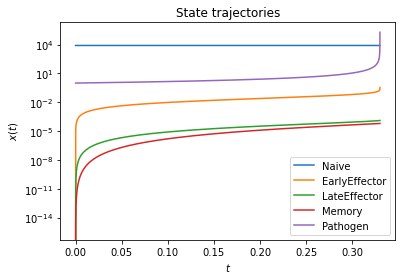

In [5]:
# Create a copy of this simulation condition
edata = amici.ExpData(res[EDATAS][0])
edata.setTimepoints(np.linspace(0, 0.33011, 5000))
amici_solver = amici_model.getSolver()
rdata = amici.runAmiciSimulation(amici_model, amici_solver, edata)

# Visualize state trajectories
plot_state_trajectories(rdata, model=amici_model)
plt.yscale("log")

We can see a steep increase for `Pathogen` just before the error occurs. Let's zoom in:

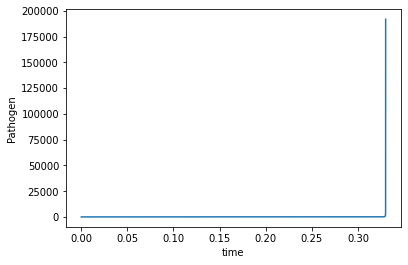

In [6]:
plt.plot(rdata.t, rdata.by_id("Pathogen"))
plt.xlabel("time")
plt.ylabel("Pathogen");

The solver is unable to handle such a steep increase. There is not much we can do. Increasing the tolerances will let the solver proceed a bit further, but this is usually not enough. Most likely there is a problem in the model or in the choice of parameter values.

## `the error test failed repeatedly or with |h| = hmin`

Let's run a simulation:

In [7]:
petab_problem = benchmark_models_petab.get_problem("Fujita_SciSignal2010")
amici_model = import_petab_problem(petab_problem, verbose=False)

np.random.seed(823)
problem_parameters = dict(
    zip(
        petab_problem.x_free_ids,
        petab_problem.sample_parameter_startpoints(n_starts=1)[0],
    )
)
res = simulate_petab(
    petab_problem=petab_problem, 
    amici_model=amici_model,
    problem_parameters=problem_parameters,
    scaled_parameters=True
)
print("Status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])

2023-01-18 10:19:29.981 - amici.swig_wrappers - DEBUG - [condition_step_00_3][CVODES:CVode:ERR_FAILURE] AMICI ERROR: in module CVODES in function CVode : At t = 7.69669 and h = 1.01007e-06, the error test failed repeatedly or with |h| = hmin. 
2023-01-18 10:19:29.982 - amici.swig_wrappers - ERROR - [condition_step_00_3][FORWARD_FAILURE] AMICI forward simulation failed at t = 7.69669: AMICI failed to integrate the forward problem


Status: ['AMICI_SUCCESS', 'AMICI_ERR_FAILURE', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS']


**What happened?**

AMICI failed to integrate the forward problem. The problem occurred for only one simulation condition, `condition_step_00_3`. The issue occurred at $t = 7.69669$, where the error test failed.
This means, the solver is unable to take a step of non-zero size without violating the choosen error tolerances.

**How to address?**

The step size is computed based on the Jacobian. Inspecting `ReturnData.J` shows us that we have rather large values in the Jacobian:

largest absolute Jacobian value: 1.19e+13


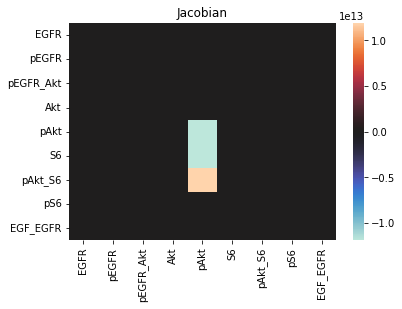

In [8]:
rdata = res[RDATAS][1]

# Show Jacobian as heatmap
plot_jacobian(rdata)

print(f"largest absolute Jacobian value: {np.max(np.abs(rdata.J)):.3g}")


In this case, the default relative error tolerance may be too high and lead too large absolute errors. 

Let's retry simulation using stricter tolerances:

In [9]:
# set stricter relative error tolerance
amici_solver = amici_model.getSolver()
amici_solver.setRelativeTolerance(amici_solver.getRelativeTolerance() / 100)

res = simulate_petab(
    petab_problem=petab_problem, 
    amici_model=amici_model,
    problem_parameters=problem_parameters,
    scaled_parameters=True,
    solver=amici_solver
)
print("Status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])
assert all(rdata.status == amici.AMICI_SUCCESS for rdata in res[RDATAS])
print("Simulations finished succesfully.")

Status: ['AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS']
Simulations finished succesfully.


## `Cvode routine CVode returned a root after reinitialization`

Let's run a simulation:

In [10]:
petab_problem = benchmark_models_petab.get_problem("Weber_BMC2015")
amici_model = import_petab_problem(petab_problem, verbose=False, force_compile=False)

np.random.seed(4)
problem_parameters = dict(
    zip(
        petab_problem.x_free_ids,
        petab_problem.sample_parameter_startpoints(n_starts=1)[0],
    )
)
res = simulate_petab(
    petab_problem=petab_problem, 
    amici_model=amici_model,
    problem_parameters=problem_parameters,
    scaled_parameters=True
)
print("Status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])

2023-01-18 10:19:30.832 - amici.swig_wrappers - ERROR - [model1_data2+model1_data1][OTHER] AMICI simulation failed: Cvode routine CVode returned a root after reinitialization. The initial step-size after the event or heaviside function is too small. To fix this, increase absolute and relative tolerances! failed with error code 2
Error occurred in:
1       0x7f9ae51510f0 amici::AmiException::AmiException(char const*, ...) + 128
2       0x7f9ae5151168 amici::CvodeException::CvodeException(int, char const*) + 24
3       0x7f9ae5144059 /home/dweindl/src/AMICI-devel/python/examples/amici_models/Weber_BMC2015/Weber_BMC2015/_Weber_BMC2015.cpython-310-x86_64-linux-gnu.so(+0x3a059) [0x7f9ae5144059]
4       0x7f9ae517c776 amici::CVodeSolver::solve(double, int) const + 86
5       0x7f9b048c1696 amici::Solver::run(double) const + 198
6       0x7f9b0


Status: ['AMICI_ERROR', 'AMICI_SUCCESS']


**What happened?**

The simulation failed because the initial step-size after an event or heaviside function was too small. The error occured during simulation of condition `model1_data1` after successful preequilibration (`model1_data2`).

**How to address?**

The error message already suggests a fix for this situation, so let's try increasing the relative tolerance:

In [11]:
amici_solver = amici_model.getSolver()
amici_solver.setRelativeTolerance(200 * amici_solver.getRelativeTolerance())

np.random.seed(4)
problem_parameters = dict(
    zip(
        petab_problem.x_free_ids,
        petab_problem.sample_parameter_startpoints(n_starts=1)[0],
    )
)
res = simulate_petab(
    petab_problem=petab_problem, 
    amici_model=amici_model,
    problem_parameters=problem_parameters,
    scaled_parameters=True,
    solver=amici_solver
)
print("Status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])

Status: ['AMICI_SUCCESS', 'AMICI_SUCCESS']


## `AMICI encountered a NaN / Inf value for [...]`

Let's run a simulation:

In [12]:
petab_problem = benchmark_models_petab.get_problem("Borghans_BiophysChem1997")
amici_model = import_petab_problem(petab_problem, verbose=False)

np.random.seed(18)
problem_parameters = dict(
    zip(
        petab_problem.x_free_ids,
        petab_problem.sample_parameter_startpoints(n_starts=1)[0],
    )
)
res = simulate_petab(
    petab_problem=petab_problem, 
    amici_model=amici_model,
    problem_parameters=problem_parameters,
    scaled_parameters=True
)
print("Status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])

2023-01-18 10:19:31.288 - amici.swig_wrappers - WARNING - [model1_data1][AMICI:NaN] AMICI encountered a NaN value for xdot[2] (A_state)
2023-01-18 10:19:31.288 - amici.swig_wrappers - WARNING - [model1_data1][AMICI:NaN] AMICI encountered a NaN value for w[6] (flux_v7_v_6)
2023-01-18 10:19:31.289 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:OTHER] AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
2023-01-18 10:19:31.290 - amici.swig_wrappers - ERROR - [model1_data1][FORWARD_FAILURE] AMICI forward simulation failed at t = 0: AMICI failed to integrate the forward problem


Status: ['AMICI_FIRST_RHSFUNC_ERR']


**What happened?**

The forward simulation failed because AMICI encountered a `NaN` value when simulating condition `model1_data1`.
Then `NaN`s occurred in $\dot x$ and $w$ (model expressions, such as reaction fluxes or assignment rules). Furthermore, the failure occurred at the first call, so at $t = t_0$ (here: $t = 0$).

**How to address?**

The `NaN` in $\dot x$ is most likely a consequence of the one in $w$. (A subset of) the dependency tree looks something like:

[![](https://mermaid.ink/img/pako:eNpdkjFvwyAQhf8KQsqWqJkZOqULa7vhDGdDGhQbED7XoCj_vUTB7rkeLH-Pu8fjzJ13Xhsu-HeEcGVfp8ax8tzUTbDOuxHB4Xh-iUEFwQJEGAyauKioUDC0g6mcjiodBbPOooWeFQdcl1QSG0EqKZiEzrcWXNVmNQtmUohmHG1JsPRqj-r5EkynN41VzioL5tvRxB9oe_Osfi3sdiVJPQw7HN5XChvCDa2tM-2caeNM-yqkBcjmkjpI6iCpg6QO8l-KVKf0yriMl9JfaZnM5kQrJ8JreabpMk2XqUumFhX4ng8mDmB1uTX3p9ZwvJrBNFyUT20uMPXY8MY9SilM6D-z67jAOJk9n4Iuv_9kody3gYsL9OOqfmiLPlbx8Qt1s7uz?type=png)](https://mermaid.live/edit#pako:eNpdkjFvwyAQhf8KQsqWqJkZOqULa7vhDGdDGhQbED7XoCj_vUTB7rkeLH-Pu8fjzJ13Xhsu-HeEcGVfp8ax8tzUTbDOuxHB4Xh-iUEFwQJEGAyauKioUDC0g6mcjiodBbPOooWeFQdcl1QSG0EqKZiEzrcWXNVmNQtmUohmHG1JsPRqj-r5EkynN41VzioL5tvRxB9oe_Osfi3sdiVJPQw7HN5XChvCDa2tM-2caeNM-yqkBcjmkjpI6iCpg6QO8l-KVKf0yriMl9JfaZnM5kQrJ8JreabpMk2XqUumFhX4ng8mDmB1uTX3p9ZwvJrBNFyUT20uMPXY8MY9SilM6D-z67jAOJk9n4Iuv_9kody3gYsL9OOqfmiLPlbx8Qt1s7uz)

Always look for the most basic (furthest up) model quantities.
In cases where there non-finite values occur in expressions further down, rerunning the simulation after calling `Model.setAlwaysCheckFinite(True)` may give some further hints on where the issue originates.

The `NaN` in $w$ occurred for `flux_v7_v_6` (see error log), i.e. when computing the reaction flux for reaction `v7_v_6`. As $w$ only depends on $(t, p, k, x)$ and no non-finite values have been reported for those, the issue has to be in the respective flux equation.

Let's look at that expression. This can either be done by inspecting the underlying SBML model (e.g., using COPASI), or by checking the generated model code:

In [13]:
# model name and source code location
model_name = amici_model.module.__package__
model_src_dir = Path(amici_model.module.__file__).parents[1]

# find the problematic expression in the model source code
!grep flux_v7_v_6 {model_src_dir}/{model_name}_w.cpp

    flux_v7_v_6 = 1.0*std::pow(A_state, 2)*Vd*std::pow(Z_state, n_par)/((std::pow(A_state, 2) + std::pow(Kp, 2))*(std::pow(Kd, n_par) + std::pow(Z_state, n_par)));  // w[6]


What could go wrong? We can obtain `NaN` from any of these symbols symbols being `NaN`, or through division by zero.

Let's let's check the denominator first: $$(A\_state^2 + Kp^2)*(Kd^{n\_par} + Z\_state^{n\_par})$$


`A_state` and `Z_state` are state variables, `Kd`, `K_p`, and `n_par` are parameters.

As the error occurred at $t = t_0$, let's ensure the initial state is non-zero and finite:

In [14]:
rdata = res[RDATAS][0]
edata = res[EDATAS][0]
# check initial states
x0 = dict(zip(amici_model.getStateIds(), rdata.x0))
print(f"{x0=}")

x0={'Z_state': 0.6869701913398437, 'Y_state': 0.2977237418558598, 'A_state': 0.1116031306650328}


The initial states are fine - the first multiplicand is non-zero, as $x_0$ was non-zero. 

So let's check the parameter values occurring in the second multiplicand:

In [15]:
# we have to account for the chosen parameter scale
from itertools import starmap
unscaled_parameter = dict(zip(
    amici_model.getParameterIds(),
    starmap(amici.getUnscaledParameter, zip(edata.parameters, edata.pscale)),
))
print(dict((p, unscaled_parameter[p]) for p in ('Kd', 'Kp', 'n_par')))

{'Kd': 0.028491925689008366, 'Kp': 1002.513636749445, 'n_par': 7816.430091706722}


Considering that `n_par` occurrs as exponent, it's magnitude looks pretty high.
This term is very likely causing the problem - let's check:

In [16]:
print(f"{x0['Z_state']**unscaled_parameter['n_par'] + unscaled_parameter['Kd']**unscaled_parameter['n_par']=}")

x0['Z_state']**unscaled_parameter['n_par'] + unscaled_parameter['Kd']**unscaled_parameter['n_par']=0.0


Indeed... No way we can fix this for the given model.
This was most likely a very unrealistic parameter value, originating from a too high upper parameter bound for `n_par`.
Therefore, if this error occurs during optimization, a first step could be adapting the respective parameter bounds.
In other cases, this may be a result of unfortunate arrangement of model expressions, which can sometimes be solved by passing a suitable simplification function to the model import.

<a id='unsuccessful_factorization'></a>

## `Steady state sensitivity computation failed due to unsuccessful factorization of RHS Jacobian`

Let's run a simulation:

In [17]:
petab_problem = benchmark_models_petab.get_problem("Blasi_CellSystems2016")
with suppress(KeyError):
    del os.environ["AMICI_EXPERIMENTAL_SBML_NONCONST_CLS"]
amici_model = import_petab_problem(
    petab_problem, 
    verbose=False,
    force_compile=True,
    model_name="Blasi_CellSystems2016_1"
)

amici_solver = amici_model.getSolver()
amici_solver.setSensitivityMethod(amici.SensitivityMethod.forward)
amici_solver.setSensitivityOrder(amici.SensitivityOrder.first)

np.random.seed(150)
problem_parameters = dict(
    zip(
        petab_problem.x_free_ids,
        petab_problem.sample_parameter_startpoints(n_starts=1)[0],
    )
)
res = simulate_petab(
    petab_problem=petab_problem, 
    amici_model=amici_model,
    problem_parameters=problem_parameters,
    scaled_parameters=True,
    solver=amici_solver,
)
print("Status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])

2023-01-18 10:19:41.054 - amici.swig_wrappers - ERROR - [control][OTHER] AMICI simulation failed: Steady state sensitivity computation failed due to unsuccessful factorization of RHS Jacobian
Error occurred in:
1       0x7f9b0487b710 amici::AmiException::AmiException(char const*, ...) + 128
2       0x7f9b047ae3a9 /home/dweindl/src/AMICI-devel/python/sdist/amici/_amici.cpython-310-x86_64-linux-gnu.so(+0xb43a9) [0x7f9b047ae3a9]
3       0x7f9b048750de amici::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 4062
4       0x7f9b04875557 /home/dweindl/src/AMICI-devel/python/sdist/amici/_amici.cpython-310-x86_64-linux-gnu.so(+0x17b557) [0x7f9b04875557]
5       0x7f9b053caa16 GO


Status: ['AMICI_ERROR']


**What happened?**

AMICI failed to compute steadystate sensitivities, because it was not able to factorize the Jacobian.

**How to address?**

This is most likely a result of a singular Jacobian. Let's check the condition number:

In [18]:
rdata = res[RDATAS][0]
np.linalg.cond(rdata.J)

4.3447684958007174e+17

Indeed, the condition number shows that the Jacobian is numerically singular. This is usually the result of conserved quantities in the model.

There are two ways we can address that:

1. Use numerical integration to compute sensitivities, for which a singular Jacobian is not an issue. This is usually slower, though.
2. Remove any conserved quantities.

Let's try both approaches:

In [19]:
# use numerical integration
amici_model.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.integrationOnly)

res = simulate_petab(
    petab_problem=petab_problem, 
    amici_model=amici_model,
    problem_parameters=problem_parameters,
    scaled_parameters=True,
    solver=amici_solver,
)
print("Status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])

Status: ['AMICI_SUCCESS']


In [20]:
# Remove conserved quantities - this requires re-importing the model

# this is enabled by the `AMICI_EXPERIMENTAL_SBML_NONCONST_CLS` environment variable
os.environ["AMICI_EXPERIMENTAL_SBML_NONCONST_CLS"] = "1"
amici_model = import_petab_problem(
    petab_problem, 
    verbose=False,
    force_compile=True,
    model_name="Blasi_CellSystems2016_2"
)

amici_solver = amici_model.getSolver()
amici_solver.setSensitivityMethod(amici.SensitivityMethod.forward)
amici_solver.setSensitivityOrder(amici.SensitivityOrder.first)

res = simulate_petab(
    petab_problem=petab_problem, 
    amici_model=amici_model,
    problem_parameters=problem_parameters,
    scaled_parameters=True,
    solver=amici_solver,
)
print("Status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])
del os.environ["AMICI_EXPERIMENTAL_SBML_NONCONST_CLS"]

Status: ['AMICI_SUCCESS']


## `Steady state computation failed`

Let's run a simulation:

In [21]:
petab_problem = benchmark_models_petab.get_problem("Brannmark_JBC2010")
amici_model = import_petab_problem(
    petab_problem, 
    verbose=False,
)

amici_solver = amici_model.getSolver()

np.random.seed(1851)
problem_parameters = dict(
    zip(
        petab_problem.x_free_ids,
        petab_problem.sample_parameter_startpoints(n_starts=1)[0],
    )
)
res = simulate_petab(
    petab_problem=petab_problem, 
    amici_model=amici_model,
    problem_parameters=problem_parameters,
    scaled_parameters=True,
    solver=amici_solver,
)
print("Status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])

2023-01-18 10:19:52.845 - amici.swig_wrappers - ERROR - [Dose_0+Dose_0][EQUILIBRATION_FAILURE] AMICI equilibration failed: AMICI failed to integrate the forward problem
2023-01-18 10:19:52.845 - amici.swig_wrappers - ERROR - [Dose_0+Dose_0][OTHER] AMICI simulation failed: Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
1       0x7f9b0487b710 amici::AmiException::AmiException(char const*, ...) + 128
2       0x7f9b047adc01 /home/dweindl/src/AMICI-devel/python/sdist/amici/_amici.cpython-310-x86_64-linux-gnu.so(+0xb3c01) [0x7f9b047adc01]
3       0x7f9b048cd08a /home/dweindl/src/AMICI-devel/python/sdist/amici/_amici.cpython-310-x86_64-linux-gnu.so(+0x1d308a) [0x7f9b048cd08a]
4       0x7f9b048cd0cf amici::SteadystateProblem::workSteadyStateProblem(amici::Solver const&, amici::Model&, int) + 63
5       0x7f9b0487426


Status: ['AMICI_ERROR', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS']


**What happened?**

All given experimental conditions require pre-equilibration, i.e. finding a steady state. AMICI first tries find a steady state using the Newton solver, if that fails, it tries simulating until steady state, if that also failes, it tries the Newton solver from the end of the simulation. In this case, all three failed. Neither Newton's method nor simulation yielded a steadystate satisfying the required tolerances.

This can also be seen in `ReturnDataView.preeq_status` (the three statuses corresponds to Newton \#1, Simulation, Newton \#2):

In [22]:
rdata = res[RDATAS][0]
list(map(amici.SteadyStateStatus, rdata.preeq_status.flatten()))

[<SteadyStateStatus.failed_convergence: -2>,
 <SteadyStateStatus.failed: -1>,
 <SteadyStateStatus.failed_convergence: -2>]

**How to address?**

There are several ways to address that:

1. Stricter integration tolerances (preferred if affordable - higher accuracy, but generally slower)

2. Looser steadystate tolerances (lower accuracy, generally faster)

3. Increase the number of allowed steps for Newton's method

Let's try all of them:

In [23]:
# Reduce relative tolerance for integration by a factor of ten
amici_solver = amici_model.getSolver()
amici_solver.setRelativeTolerance(1/10 * amici_solver.getRelativeTolerance())

res = simulate_petab(
    petab_problem=petab_problem, 
    amici_model=amici_model,
    problem_parameters=problem_parameters,
    scaled_parameters=True,
    solver=amici_solver,
)
print("status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])

rdata = res[RDATAS][0]
print(f"preeq_status={list(map(amici.SteadyStateStatus, rdata.preeq_status.flatten()))}")
print(f"{rdata.preeq_numsteps=}")

status: ['AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS']
preeq_status=[<SteadyStateStatus.failed_convergence: -2>, <SteadyStateStatus.success: 1>, <SteadyStateStatus.not_run: 0>]
rdata.preeq_numsteps=array([[   0, 2264,    0]])


In [24]:
# Increase relative tolerance
for log10_relaxation_factor in range(1, 10):
    print(f"Relaxing tolerances by factor {10 ** log10_relaxation_factor}")
    amici_solver = amici_model.getSolver()
    amici_solver.setRelativeToleranceSteadyState(amici_solver.getRelativeToleranceSteadyState() * 10 ** log10_relaxation_factor)
    
    res = simulate_petab(
        petab_problem=petab_problem, 
        amici_model=amici_model,
        problem_parameters=problem_parameters,
        scaled_parameters=True,
        solver=amici_solver,
    )
    if all(rdata.status == amici.AMICI_SUCCESS for rdata in res[RDATAS]):
        print(f"-> Succeeded with relative steady state tolerance {amici_solver.getRelativeToleranceSteadyState()}\n")
        break
    else:
        print("-> Failed.\n")

print("status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])

rdata = res[RDATAS][0]
print(f"preeq_status={list(map(amici.SteadyStateStatus, rdata.preeq_status.flatten()))}")
print(f"{rdata.preeq_numsteps=}")

Relaxing tolerances by factor 10


2023-01-18 10:19:53.425 - amici.swig_wrappers - ERROR - [Dose_0+Dose_0][EQUILIBRATION_FAILURE] AMICI equilibration failed: AMICI failed to integrate the forward problem
2023-01-18 10:19:53.426 - amici.swig_wrappers - ERROR - [Dose_0+Dose_0][OTHER] AMICI simulation failed: Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
1       0x7f9b0487b710 amici::AmiException::AmiException(char const*, ...) + 128
2       0x7f9b047adc01 /home/dweindl/src/AMICI-devel/python/sdist/amici/_amici.cpython-310-x86_64-linux-gnu.so(+0xb3c01) [0x7f9b047adc01]
3       0x7f9b048cd08a /home/dweindl/src/AMICI-devel/python/sdist/amici/_amici.cpython-310-x86_64-linux-gnu.so(+0x1d308a) [0x7f9b048cd08a]
4       0x7f9b048cd0cf amici::SteadystateProblem::workSteadyStateProblem(amici::Solver const&, amici::Model&, int) + 63
5       0x7f9b0487426


-> Failed.

Relaxing tolerances by factor 100


2023-01-18 10:19:53.658 - amici.swig_wrappers - ERROR - [Dose_0+Dose_0][EQUILIBRATION_FAILURE] AMICI equilibration failed: AMICI failed to integrate the forward problem
2023-01-18 10:19:53.658 - amici.swig_wrappers - ERROR - [Dose_0+Dose_0][OTHER] AMICI simulation failed: Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
1       0x7f9b0487b710 amici::AmiException::AmiException(char const*, ...) + 128
2       0x7f9b047adc01 /home/dweindl/src/AMICI-devel/python/sdist/amici/_amici.cpython-310-x86_64-linux-gnu.so(+0xb3c01) [0x7f9b047adc01]
3       0x7f9b048cd08a /home/dweindl/src/AMICI-devel/python/sdist/amici/_amici.cpython-310-x86_64-linux-gnu.so(+0x1d308a) [0x7f9b048cd08a]
4       0x7f9b048cd0cf amici::SteadystateProblem::workSteadyStateProblem(amici::Solver const&, amici::Model&, int) + 63
5       0x7f9b0487426


-> Failed.

Relaxing tolerances by factor 1000


2023-01-18 10:19:53.867 - amici.swig_wrappers - ERROR - [Dose_0+Dose_0][EQUILIBRATION_FAILURE] AMICI equilibration failed: AMICI failed to integrate the forward problem
2023-01-18 10:19:53.867 - amici.swig_wrappers - ERROR - [Dose_0+Dose_0][OTHER] AMICI simulation failed: Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
1       0x7f9b0487b710 amici::AmiException::AmiException(char const*, ...) + 128
2       0x7f9b047adc01 /home/dweindl/src/AMICI-devel/python/sdist/amici/_amici.cpython-310-x86_64-linux-gnu.so(+0xb3c01) [0x7f9b047adc01]
3       0x7f9b048cd08a /home/dweindl/src/AMICI-devel/python/sdist/amici/_amici.cpython-310-x86_64-linux-gnu.so(+0x1d308a) [0x7f9b048cd08a]
4       0x7f9b048cd0cf amici::SteadystateProblem::workSteadyStateProblem(amici::Solver const&, amici::Model&, int) + 63
5       0x7f9b0487426


-> Failed.

Relaxing tolerances by factor 10000
-> Succeeded with relative steady state tolerance 0.01

status: ['AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS']
preeq_status=[<SteadyStateStatus.failed_convergence: -2>, <SteadyStateStatus.success: 1>, <SteadyStateStatus.not_run: 0>]
rdata.preeq_numsteps=array([[  0, 577,   0]])


That fixed the error, and took only a quarter of the number steps as the previous run, but at the cost of much lower accuracy.

In [25]:
# Let's try increasing the number of Newton steps
# (this is 0 by default, so the Newton solver wasn't used before, 
#  as can be seen from the 0 in `rdata.preeq_numsteps[0]`)
amici_solver = amici_model.getSolver()
amici_solver.setNewtonMaxSteps(10**4)

res = simulate_petab(
    petab_problem=petab_problem, 
    amici_model=amici_model,
    problem_parameters=problem_parameters,
    scaled_parameters=True,
    solver=amici_solver,
)
print("status:", [amici.simulation_status_to_str(rdata.status) for rdata in res[RDATAS]])

rdata = res[RDATAS][0]
print(f"preeq_status={list(map(amici.SteadyStateStatus, rdata.preeq_status.flatten()))}")
print(f"{rdata.preeq_numsteps=}")

2023-01-18 10:19:54.341 - amici.swig_wrappers - ERROR - [Dose_0+Dose_0][EQUILIBRATION_FAILURE] AMICI equilibration failed: AMICI failed to integrate the forward problem
2023-01-18 10:19:54.341 - amici.swig_wrappers - ERROR - [Dose_0+Dose_0][OTHER] AMICI simulation failed: Steady state computation failed. First run of Newton solver failed: RHS could not be factorized. Simulation to steady state failed. Second run of Newton solver failed: RHS could not be factorized.
Error occurred in:
1       0x7f9b0487b710 amici::AmiException::AmiException(char const*, ...) + 128
2       0x7f9b047adc01 /home/dweindl/src/AMICI-devel/python/sdist/amici/_amici.cpython-310-x86_64-linux-gnu.so(+0xb3c01) [0x7f9b047adc01]
3       0x7f9b048cd08a /home/dweindl/src/AMICI-devel/python/sdist/amici/_amici.cpython-310-x86_64-linux-gnu.so(+0x1d308a) [0x7f9b048cd08a]
4       0x7f9b048cd0cf amici::SteadystateProblem::workSteadyStateProblem(amici::Solver const&, amici::Model&, int) + 63
5       0x7f9b0487426


status: ['AMICI_ERROR', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS', 'AMICI_SUCCESS']
preeq_status=[<SteadyStateStatus.failed_factorization: -3>, <SteadyStateStatus.failed: -1>, <SteadyStateStatus.failed_factorization: -3>]
rdata.preeq_numsteps=array([[   0, 1105,    0]])


Increasing the maximum number of Newton steps doesn't seem to help here. The Jacobian was numerically singular and its factorization failed. This can be a result of conserved quantities in the model. Section [`Steady state sensitivity computation failed due to unsuccessful factorization of RHS Jacobian`](#unsuccessful_factorization) shows how to address that.